## 4.2 線形補間デモザイク

### この節について

この節では、画像サイズを変えないデモザイク処理を解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_4_2.ipynb

### 準備

まず3章で行ったライブラリーのインストールと、モジュールのインポートを行います。
内容については各節を参照ください。

In [2]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then wget https://raw.githubusercontent.com/moizumi99/camera_raw_process/master/camera_raw_process.py; fi

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合`! rm /content/.cache/matplotlib/fontList.json`を実行して、
# Runtime->Restart Runtimeで再実行

from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


次に画像のダウンロードと読み込みを行います。

今回はラズベリーパイで撮影したこの画像を使用します。

![チャート画像](https://raw.githubusercontent.com/moizumi99/raw_process/master/chart.jpg)

In [3]:
# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://raw.githubusercontent.com/moizumi99/camera_raw_process/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

ラズベリーパイによるRAW画像の撮影方法については付録を参照ください。

### 簡易デモザイク処理の問題点

前節では、デモザイク処理（Bayer配列の画像からフルカラーの画像を作り出す処理）として、簡易的な画像サイズが1/4になるものを使いました。
単純な処理の割に意外なほどきれいな出力が得られるのですが、いかんせん画像が小さくなるのは問題です。また、出力画像が1/4になるので、細かい部分は潰れてしまいます。

この点を確認するために、先程の画像を`raw_process`モジュールを使ってRGB画像に変換してみましょう。

In [24]:
# raw_processからインポートしたblack_level_correction関数を使用してブラックレベル補正。
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
# raw_processからインポートしたwhite_balance()関数を使って、ホワイトバランス調整。
wb_raw = white_balance(blc_raw, raw.camera_whitebalance, raw.raw_colors)
# raw_processからインポートしたsimple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_raw, raw.raw_pattern)
# ラズベリーパイのRAW画像は10bitなので、1024で正規化しておく。
white_level = 1024.0
dms_img = dms_img / white_level
# raw_processからインポートしたgamma_crrection()関数を使って、ガンマ補正。
gmm_img = gamma_correction(dms_img, 2.2)

表示してみます。

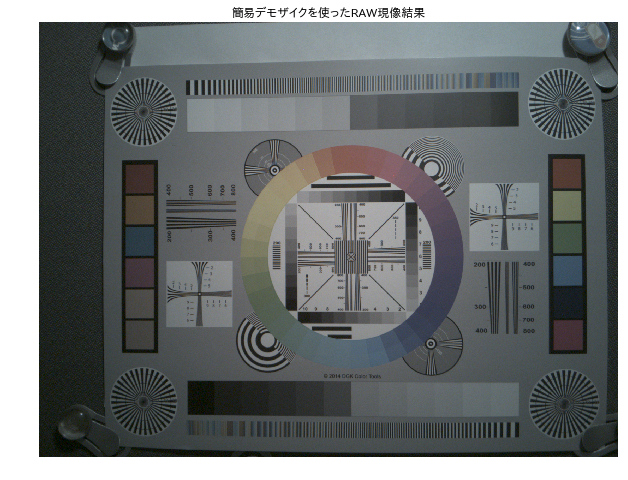

In [25]:
# サイズ設定
plt.figure(figsize=(16, 8))
plt.imshow(gmm_img)
plt.axis('off')
plt.title(u"簡易デモザイクを使ったRAW現像結果")
plt.show()

この画像のサイズとRAWデータのサイズを見てみましょう。

In [26]:
print("現像後のサイズ = ", gmm_img.shape)
print("RAWデータのサイズ = ", raw_array.shape)

現像後のサイズ =  (1232, 1640, 3)
RAWデータのサイズ =  (2464, 3280)


この画像の大きさは縦1232ライン、横1640画素であることがわかります。それに対して元のRAW画像のサイズは縦2464ライン、横3280画素です。ちょうど２分の１ずつになっています。

最初に表示したJPEG画像と大きさを合わせて並べてみましょう。まずはJPEG画像をnumpyのarrayとして読み込みます。

In [27]:
# matplotlibのモジュールimageを使ってJPEG画像を読み込みます。
from matplotlib import image
jpg_img = image.imread("chart.jpg")
# 0-1の範囲で正規化します
jpg_img = jpg_img / jpg_img.max()
# 画像サイズを取得します
h2, w2, c = jpg_img.shape

次に、このJPEGから作ったデータと、先程簡易RAW現像したデータを同じnumpy arrayに代入してみます。

In [28]:
# JPEG画像の横幅の倍の幅を持つnumpy arrayを作成
two_img = np.zeros((h2, w2 * 2, c))
# numpy arrayの右半分にJPEG画像のデータをはめこむ。
two_img[0:, w2:, :] = jpg_img
# 左半分に簡易RAW現像したデータをはめこむ。
two_img[h//4:h//4+h//2, w//4:w//4+w//2, :] = gmm_img

ならべてた画像データを表示してみましょう。

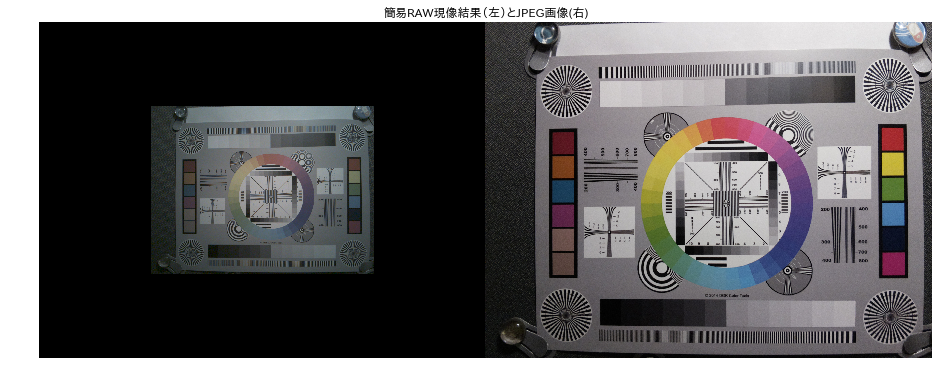

In [29]:
plt.figure(figsize=(16, 8))
plt.imshow(two_img)
plt.axis('off')
plt.title(u"簡易RAW現像結果（左）とJPEG画像(右)")
plt.show()

色合いが違う、明るさが違う、という点は無視しても、サイズの違いは明白です。

次は拡大してみましょう。こんどは表示サイズが同じになるように調整します。

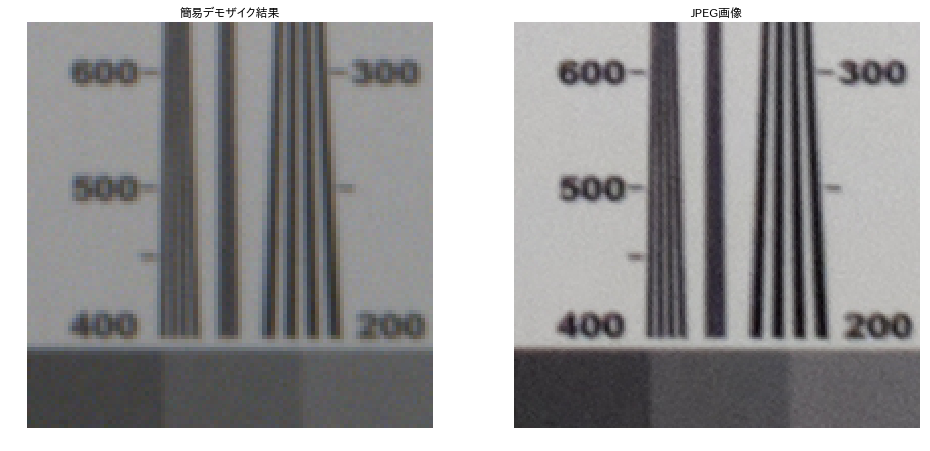

In [41]:
# 表示サイズ設定
plt.figure(figsize=(16, 8))

# まずは簡易RAW現像したファイルの表示。
# 縦１列、横２列に表示領域を設定。
# そのうち１つ目に画像表示。
plt.subplot(1, 2, 1)
# 簡易RAW現像した画像の表示したい範囲。
y1, x1 = 740, 835
dy1, dx1 = 100, 100
# 選択した範囲を表示
plt.imshow(gmm_img[y1:y1+dy1, x1:x1+dx1])
plt.axis('off')
plt.title("簡易デモザイク結果")

# 次にJPEG画像の表示。
# 縦１列、横２列のうち２つめに表示。
plt.subplot(1, 2, 2)
# 画像位置を簡易RAW現像のものに合わせる
y2, x2 = y1 * 2, x1 * 2
dy2, dx2 = dy1 * 2, dx1 * 2
plt.imshow(jpg_img[y2:y2+dy2, x2:x2+dx2])
plt.axis('off')
plt.title(u"JPEG画像")
# 実際に表示。
plt.show()

明るさやコントラストの違いがまっさきに目につきますが、それは次回以降考えましょう。
解像度に注目すると、意外なほど健闘はしているのですが、縦のラインの分解能が低かったりする点がわかると思います。このあたりは簡易デモザイクによる画像サイズの低下の影響があるといえるでしょう。

現代のカメラ内部のデモザイクはかなり高度な処理をしているはずなので、右側のJPEG画像並みの解像度を得るのは難しいと思いますが、せめてもとの画像サイズを取り戻せるような処理を導入してみましょう。

### 線形補完法

デモザイクアルゴリズムの中で、縮小する方法の次に簡単なのは、線形補間法です。
線形補間というとものものしいですが、ようするに、距離に応じて間の値をとるわけです。たとえば、緑の画素ならこうなります。

![緑画像の線形補間](fig_4_2_1.png "緑画像の線形補間")

赤の画素ではこうです。

![赤画像の線形補間](fig_4_2_2.png "赤画像の線形補間")

青の画素でも、赤の場合と同じような補完を行います。

では実際やってみましょう。

In [42]:
# 画像のヘリの部分で折り返すためのヘルパー関数
def mirror(x, min, max):
    if x < min:
        return min - x
    elif x >= max:
        return 2 * max - x - 2
    else:
        return x

dms_img = np.zeros((h, w, 3))
bayer_pattern = raw.raw_pattern
for y in range(0, h):
    for x in range(0, w):
        color = bayer_pattern[y % 2, x % 2]
        y0 = mirror(y-1, 0, h)
        y1 = mirror(y+1, 0, h)
        x0 = mirror(x-1, 0, w)
        x1 = mirror(x+1, 0, w)
        if color == 0:
            dms_img[y, x, 0] = wb_raw[y, x]
            dms_img[y, x, 1] = (wb_raw[y0, x] + wb_raw[y, x0] + wb_raw[y, x1] + wb_raw[y1, x])/4
            dms_img[y, x, 2] = (wb_raw[y0, x0] + wb_raw[y0, x1] + wb_raw[y1, x0] + wb_raw[y1, x1])/4
        elif color == 1:
            dms_img[y, x, 0] = (wb_raw[y, x0] + wb_raw[y, x1]) / 2
            dms_img[y, x, 1] = wb_raw[y, x]
            dms_img[y, x, 2] = (wb_raw[y0, x] + wb_raw[y1, x]) / 2
        elif color == 2:
            dms_img[y, x, 0] = (wb_raw[y0, x0] + wb_raw[y0, x1] + wb_raw[y1, x0] + wb_raw[y1, x1])/4
            dms_img[y, x, 1] = (wb_raw[y0, x] + wb_raw[y, x0] + wb_raw[y, x1] + wb_raw[y1, x])/4
            dms_img[y, x, 2] = wb_raw[y, x]
        else:
            dms_img[y, x, 0] = (wb_raw[y0, x] + wb_raw[y1, x]) / 2
            dms_img[y, x, 1] = wb_raw[y, x]
            dms_img[y, x, 2] = (wb_raw[y, x0] + wb_raw[y, x1]) / 2

画像のサイズを確認します。

In [43]:
print(dms_img.shape)

(2464, 3280, 3)


元のRAW画像と同じサイズになっているようです。

画像を確認してみましょう。まずは残っているガンマ補正処理を行います。

In [44]:
# ガンマ補正
gmm_full_img = gamma_correction(dms_img / white_level, 2.2)

表示します。

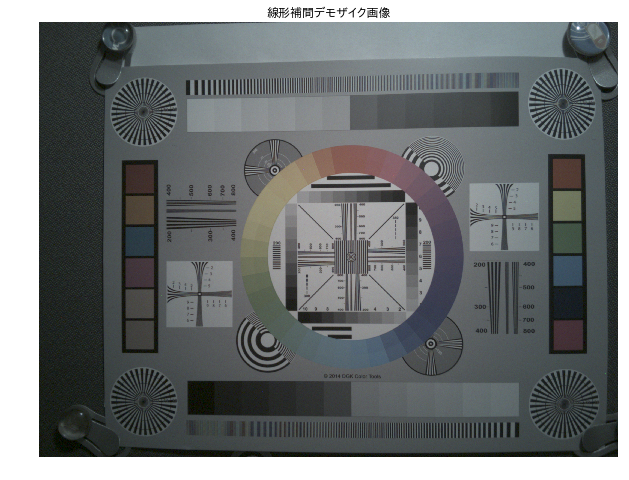

In [45]:
# サイズ設定
plt.figure(figsize=(16, 8))
plt.imshow(gmm_full_img)
plt.axis('off')
plt.title(u"線形補間デモザイク画像")
plt.show()

それでは、JPEG画像と並べて表示してみましょう。

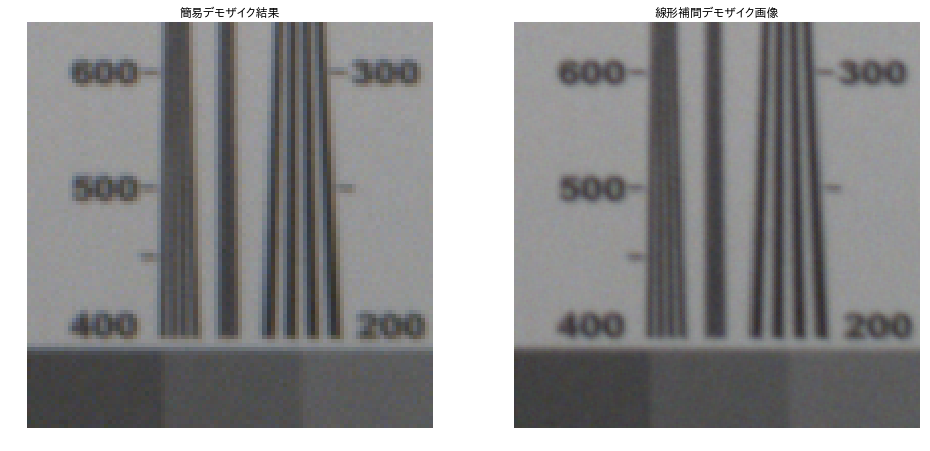

In [46]:
# 表示サイズ設定
plt.figure(figsize=(16, 8))

# まずは簡易RAW現像したファイルの描画。
plt.subplot(1, 2, 1)
y1, x1 = 740, 835
dy1, dx1 = 100, 100
plt.imshow(gmm_img[y1:y1+dy1, x1:x1+dx1])
plt.axis('off')
plt.title("簡易デモザイク結果")

# 今回RAW現像した画像の描画。
plt.subplot(1, 2, 2)
y2, x2 = y1 * 2, x1 * 2
dy2, dx2 = dy1 * 2, dx1 * 2
plt.imshow(gmm_full_img[y2:y2+dy2, x2:x2+dx2])
plt.axis('off')
plt.title(u"線形補間デモザイク画像")

# 実際に表示。
plt.show()

右側の線形補間した結果では、縦のラインがより細い部分まで分解されていることがわかります。とりあえずは成功としましょう。

なお、より高性能なデモザイクは６章の応用編でとりあげます。

### 処理の高速化

今回のデモザイクもコードの読みやすさを優先させてあります。高速化しておきましょう。

高速化に当たっては、数値計算ライブラリscipyのsignalモジュールを使います。

In [47]:
from scipy import signal

def demosaic(raw_array, raw_colors):
    """
    線形補間でデモザイクを行う

    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ。
    raw_colors: numpy array
        RAW画像のカラーチャンネルマトリクス。
        通常Rawpyのraw_colorsを用いて与える。

    Returns
    -------
    dms_img: numpy array
        出力RAW画像。
    """
    h, w = raw_array.shape
    dms_img = np.zeros((h, w, 3))
    
    # 緑画素の処理
    # 元のRAW画像から緑画素だけ抜き出す
    green = raw_array.copy()
    green[(raw_colors == 0) | (raw_colors == 2)] = 0
    # 緑画素の線形補間フィルター
    # [[0, 1, 0]]
    #  [1, 4, 1]
    #  [0, 1, 0]] / 4.0
    g_flt = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]) / 4.0
    # フィルターの適用
    # boundary='symm': 画像のヘリで折り返す。
    # mode='same': 出力画像サイズは入力画像と同じ。
    dms_img[:, :, 1] = signal.convolve2d(green, g_flt, boundary='symm', mode='same')

    # 元のRAW画像から赤画素だけ抜き出す
    red = raw_array.copy()
    red[raw_colors != 0] = 0
    # 赤画素の線形補間フィルター
    # [[1, 2, 1]]
    #  [2, 4, 2]
    #  [1, 2, 1]] / 4.0
    rb_flt = np.array([[1 / 4, 1 / 2, 1 / 4], [1 / 2, 1, 1 / 2], [1 / 4, 1 / 2, 1 / 4]])
    # フィルターの適用
    dms_img[:, :, 0] = signal.convolve2d(red, rb_flt, boundary='symm', mode='same')

    # 元のRAW画像から青画素だけ抜き出す
    blue = raw_array.copy()
    blue[raw_colors != 2] = 0
    # 青画素の線形補間フィルターは赤と共通
    # フィルターの適用
    dms_img[:, :, 2] = signal.convolve2d(blue, rb_flt, boundary='symm', mode='same')
    return dms_img

ここで使ったconvolve2dは、線形フィルターを画像などの２次元データに畳み込む処理です。

上記の場合は、入力画素の周辺3x3画素を取り出し、その一つ一つの画素とフィルターの値を掛け合わした上で合計し出力するという処理をしています。

例えばこのコードの場合、緑画素なら、$gin$、$gout$を緑画素の入力、出力とすると

$$ g =  \frac{1}{4}
\begin{bmatrix}
    0 & 1 & 0 \\
    1 & 4 & 1 \\
    0 & 1 & 0
    \end{bmatrix} $$

$$ gout_{x, y}= \sum_{i=-1}^{+1}\sum_{j=-1}^{+1} gin_{x+i, y+i} g_{i, j}$$

という処理を行います。これで入力画素が緑画素の場合、上下左右には緑画素がないので入力画素がそのまま出力されます。そうでない場合は、上下左右の緑がその平均値が出力されます。

この`demosaic()`関数は`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py`

としてダウンロードした後、

`from raw_process import demosaic`

としてインポートしてください。

### まとめ

この節では線形補間によるデモザイク処理を行いました。次は[欠陥画素補正](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_4_3.ipynb)を行います。